# Thomas Wildfire Air Quality Index During 2017 and 2018

Author: Vanessa Salgado

Link to GitHub repository: https://github.com/Vanessa-Salgado/eds220-hw4-task3

## Purpose
The Thomas Fires was a massive wildfire that affected Ventura and Santa Barbara counties in December 2017. The Thomas Fire destroyed at least 1,063 structures, while damaging 280 others; and the fire caused over $2.2 billion (2018 USD) in damages. As of August 2020, the Thomas Fire is California's tenth-most destructive wildfire. In this notebook we analyze the Air Quality Index that occured the time leading up to and after the Thomas Fire. We will create a map of the Thomas Fire perimeter to visualize the damage using `landsat 8` imagery 

### Highlights

* Data wrangling and data cleaning  with pandas
* 
* Creating and customizing raster map 

## Dataset Description

In this notebook we use 3 datasets: 

**1) US EPA Air Quality Index(AQI)**

The US Environmentla Protection Agency air quality collects data from outdoor monitors across the United States, Puerto Rico, and the U.S Virgin Islands. The data comes primarily from the AQS (Air Quality System) database.

This data set was downloaded from the EPA AirData portal. The data was available from the Pre-Generate Data Files that collects daily AQI readings by county per year. The files are updated twice per year: once in June to capture the complete data for the prior year and once in December to capture the data for the summer (ozone season). For this analysis we collect the will use the following columns of interest: 

* **County Name:** Santa Barbara is the county of interest
* **Date:** 2017 and 2018 are the years of interest in order to study the before and after affects of the Thomas Fire.
* **AQI:** Air Quality Index reading in AQI Numbers

Access here:https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

**2)Landsat 8 Surface Reflectance Satellite Data**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution (Landsat Collection in MPC). Data should be used for visualization purposes only.

Access here: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

**3)California Thomas Fire Perimeter**

A shapefile of fire perimeters in California during 2017. The state of California contains geospatial data of  California's Fire Wildfire Perimeters and Prescribed Burns hosted on the CAL FIRE AGeoportal. 

Access here: https://www.epa.gov/air-trends/air-quality-cities-and-counties

## Final Output of 


In [1]:
# TBD

## Data Exploration for AQI Readings Through Thomas Fire

### Import Libraries and functions:  

In [2]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Import AQI Data
Import County AQI data via the URL from the EPA for years 2017 and 2018. 

In [3]:
# read in data from 2017 URL 
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip") 
# read in data from 2017 URL 
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

#### Preparing and Cleaning AQI Data
We combine the 2017 and 2017 datasets to analyze the change in AQI of the time series data.

In [4]:
 # combine 2017 and 2018 into a single df using concatenation
aqi = pd.concat([aqi_17, aqi_18])

Check if the combined dataframe `aqi` dimensions correspond to the addition of rows from `aqi_17` and `aqi_18`: 

In [5]:
print("Are dimensions correct after combining dataframes:",
     aqi.shape[0] == aqi_17.shape[0] + aqi_18.shape[0])

Are dimensions correct after combining dataframes: True


The next step is to clean up the column names and isolate the columns of interest.

In [14]:
#clean the column names, removing spaces and turning all strings to lowercase
aqi.columns = aqi.columns.str.lower().str.replace(' ','_') #code provided

# create subset of SB County w/desired columns
aqi_sb = aqi.loc[aqi['county_name']=='Santa Barbara', #row-selection
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']] #column-selection

# change date column to object type = datatime
aqi_sb.date = pd.to_datetime(aqi_sb.date)

## Analysis on Impact on AQI

Inspecting the the daily AQI of Santa Barbara County would introduce a lot of noise into the analysis. A rolling 5 day average would seem like an appropiate modification to analyze daily AQI readings. 

In [20]:
# set date column as the index
aqi_sb = aqi_sb.set_index('date')

In [21]:
# add new column w/5-day rolling avg
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

In [22]:
aqi_sb_subset

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
date,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12
2017-01-02,36,Good,Ozone,06-083-4003,11
2017-01-03,71,Moderate,PM10,06-083-4003,12
2017-01-04,34,Good,Ozone,06-083-4003,13
2017-01-05,37,Good,Ozone,06-083-4003,12
...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11
2018-12-28,39,Good,Ozone,06-083-1021,12
2018-12-29,39,Good,Ozone,06-083-1021,12


In [23]:
aqi_sb

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,36,Good,Ozone,06-083-4003,11,37.500000
2017-01-03,71,Moderate,PM10,06-083-4003,12,48.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.000000
2017-01-05,37,Good,Ozone,06-083-4003,12,43.400000
...,...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11,38.600000
2018-12-28,39,Good,Ozone,06-083-1021,12,38.600000
2018-12-29,39,Good,Ozone,06-083-1021,12,38.200000


###  Context of AQI Measurements
It is important to show the average along with the true value of AQI to visually see if the computation and the data make intuitive sense. 

Here I attempted to find the residual of the daily aqi reading and the 5 day rollling average. 

In [24]:
# add a new column to store the differnce between the true AQI and the five day average AQI
aqi_sb['aqi_difference'] = aqi_sb['aqi'] - aqi_sb['five_day_average']

### Plotting AQI From 2017 to 2018
The purpose of this visualization is to show both the daily AQI and the 5-day average from 2017 to 2018. 

<Axes: title={'center': 'Santa Barbara Air Quality 2017-18'}, xlabel='date'>

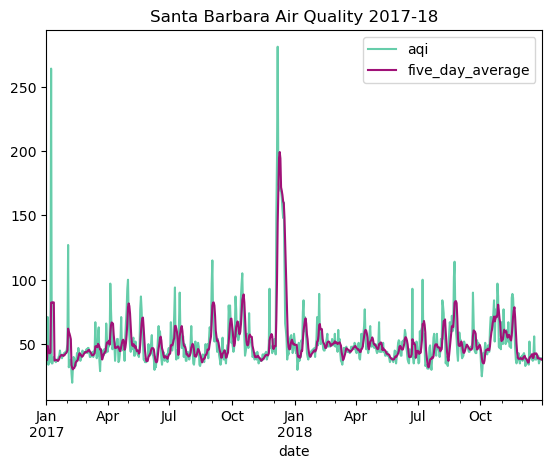

In [41]:
aqi_sb.aqi.plot(color = '#66CDAA', legend = True) 

aqi_sb.five_day_average.plot(color = '#A01177', 
                            title = 'Santa Barbara Air Quality 2017-18',
                            legend = True)

We can see the the AQI going up during the Thomas Fire in December 2017. There is a visible spike on December 2017. AQI is over 250 and nearly reaching 300 AQI index. Anything between 201 to 300 is very unhealthy and anything over 300 is deemed hazardous according to the EPA’s index. 

## Visualizing Raster Images of Thomas Fire 

### Data Exploration of the Raster Data


####  Loading Raster Data 

In [27]:
# load the landsat data
data_path = os.path.join(os.getcwd(), "data/landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(data_path)

#### Raster Exploratory Plot of Data Variables

Text(0.5, 1.0, 'swir22')

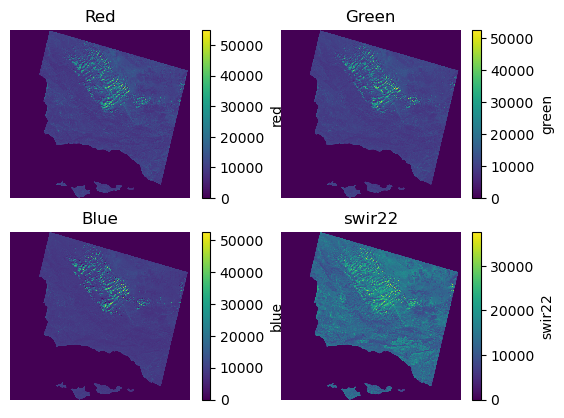

In [43]:
# exploration of landsat raster

#exploratory plot

fig, axs = plt.subplots(2, 2)

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')

landsat.red.plot(ax = axs[0, 0])
axs[0, 0].set_title('Red')
landsat.green.plot(ax = axs[0, 1])
axs[0, 1].set_title('Green')
landsat.blue.plot(ax = axs[1, 0])
axs[1, 0].set_title('Blue')
landsat.swir22.plot(ax = axs[1, 1])
axs[1, 1].set_title('swir22')

In [32]:
# check the raster's CRS
print("CRS of landsat:",landsat.rio.crs)

CRS of landsat: EPSG:32611


###  Raster Data Preparation
We need to drop the band from the data

In [33]:
# squeeze the band
landsat = landsat.squeeze(['band'])

#### True color image

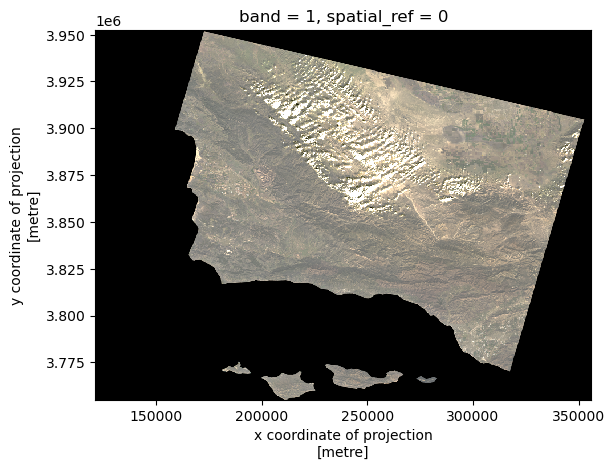

In [34]:
#plot the rgb array using robust parameter
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust= True)

#### False Color Image

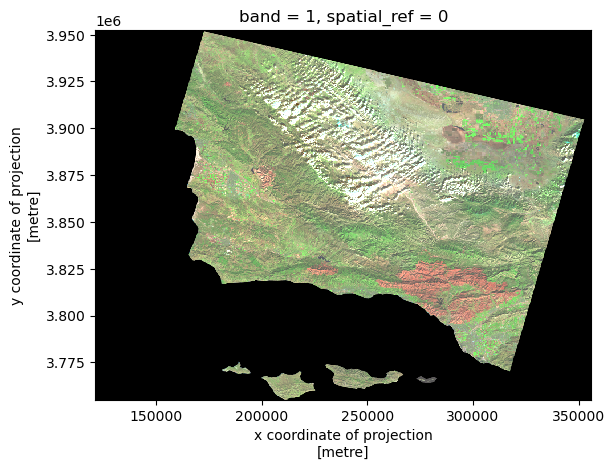

In [35]:
#plot invisible infrared and shortwave
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust= True)

#### Fire Perimeter Data

In [37]:
# make the crs same and also read the thompsons fire data+
fire = gpd.read_file("data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp")
 

# create a crop of Thomas Fire
#select only thomas fire    
thomas_fire = fire[fire['FIRE_NAME'] == 'THOMAS']  

#change the crs                               
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

### Map of Thomas Fire Perimeter

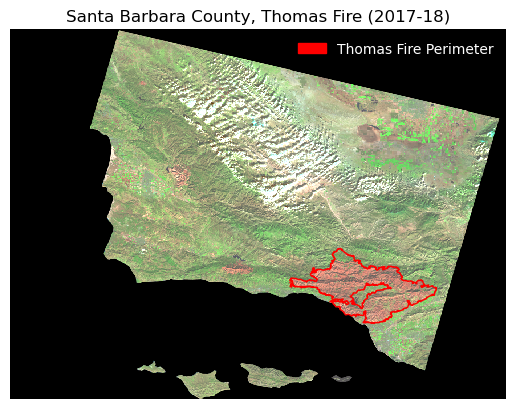

In [40]:
fig, ax = plt.subplots()
ax.axis('off') #remove axes

#--------------------------
thomas_fire.plot(ax=ax,color = 'None', edgecolor = 'red', legend=True) #plot thomas fire
thomas_patch = mpatches.Patch(color = 'red', label = 'Thomas Fire Perimeter') #legend parameters

#--------------------------
landsat[['swir22','nir08','red']].to_array().plot.imshow(robust=True) #plot SB county w/ sir, nir, and red

#--------------------------
ax.set_title('Santa Barbara County, Thomas Fire (2017-18)') # update title

#--------------------------
_ = ax.legend(handles=[thomas_patch], labelcolor = 'white',loc = 'upper right', frameon = False) #add legend,

In [ ]:
## References
California State Geoportal. (2023, August 7), California Fire Perimeters (all) [Data file] Available from: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Access date: November 28, 2023.

Earth Resources Observation And Science (EROS) Center. Collection-2 Landsat 8-9 OLI (Operational Land Imager) and TIRS (Thermal Infrared Sensor) Level-2 Science Products. U.S. Geological Survey, 2013, doi:10.5066/P9OGBGM6.

Environmental Protection Agency (EPA). (2023, November 9), Air Data: Air Quality Data Collected at Outdoor Monitors Across the US. Pre-Generated Data Files [URL] Available from: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Access date: November 28, 2023.

“Thomas Fire.” Wikipedia, Wikimedia Foundation, 9 Nov. 2023, en.wikipedia.org/wiki/Thomas_Fire. Accessed 28 Nov. 2023.